# Time-Series Forecasting: Predicting Stock Prices Using An LSTM Model

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format ='retina'  
import matplotlib.pyplot as plt

### Load Data

In [2]:
import starfishX as sx

In [46]:
df = pd.read_csv('kce+set.csv',parse_dates=['TIMESTAMP'],index_col=['TIMESTAMP'])
df.columns = ['SET','SET_Vol','KCE','KCE_Vol']
df = df.dropna()
df = df[df.index<'2021-10-08']
#df['Ratio'] = df['SET']/df['KCE']   #ลองพยายามเพิ่ม feature ขึ้นมา
df.tail(10)

,SET,SET_Vol,KCE,KCE_Vol
TIMESTAMP,,,,
2021-09-23,1631.15,43830264.0,82.75,180056.0
2021-09-27,1620.02,45721717.0,79.50,270914.0
2021-09-28,1616.50,39317956.0,79.00,124031.0
2021-09-29,1616.98,32428229.0,79.25,195390.0
2021-09-30,1605.68,34584597.0,78.75,168380.0
2021-10-01,1605.17,30349922.0,78.25,95337.0
2021-10-04,1614.48,29827920.0,78.50,65578.0
2021-10-05,1624.24,32669106.0,78.00,156218.0
2021-10-06,1619.48,34576046.0,79.25,128657.0


In [47]:
df.head(5)

,SET,SET_Vol,KCE,KCE_Vol
TIMESTAMP,,,,
2015-12-16,1299.12,8969657.0,30.38,3306.0
2015-12-17,1310.34,8756039.0,31.88,30504.0
2015-12-18,1284.92,8669704.0,30.88,23384.0
2015-12-21,1264.44,11878327.0,31.00,12484.0
2015-12-22,1261.66,11938833.0,31.00,21108.0


In [48]:
df.tail(5)

,SET,SET_Vol,KCE,KCE_Vol
TIMESTAMP,,,,
2021-10-01,1605.17,30349922.0,78.25,95337.0
2021-10-04,1614.48,29827920.0,78.50,65578.0
2021-10-05,1624.24,32669106.0,78.00,156218.0
2021-10-06,1619.48,34576046.0,79.25,128657.0
2021-10-07,1633.72,33365780.0,79.00,91145.0


In [4]:
#df = sx.loadHistData_v2('kce',start='2018-01-01',end='2021-07-31')
#df.sample(1)

In [5]:
#df = df[['Open','High','Low','Close','Volume']]
#df = df[['Close','Volume']]
#df.head(5)

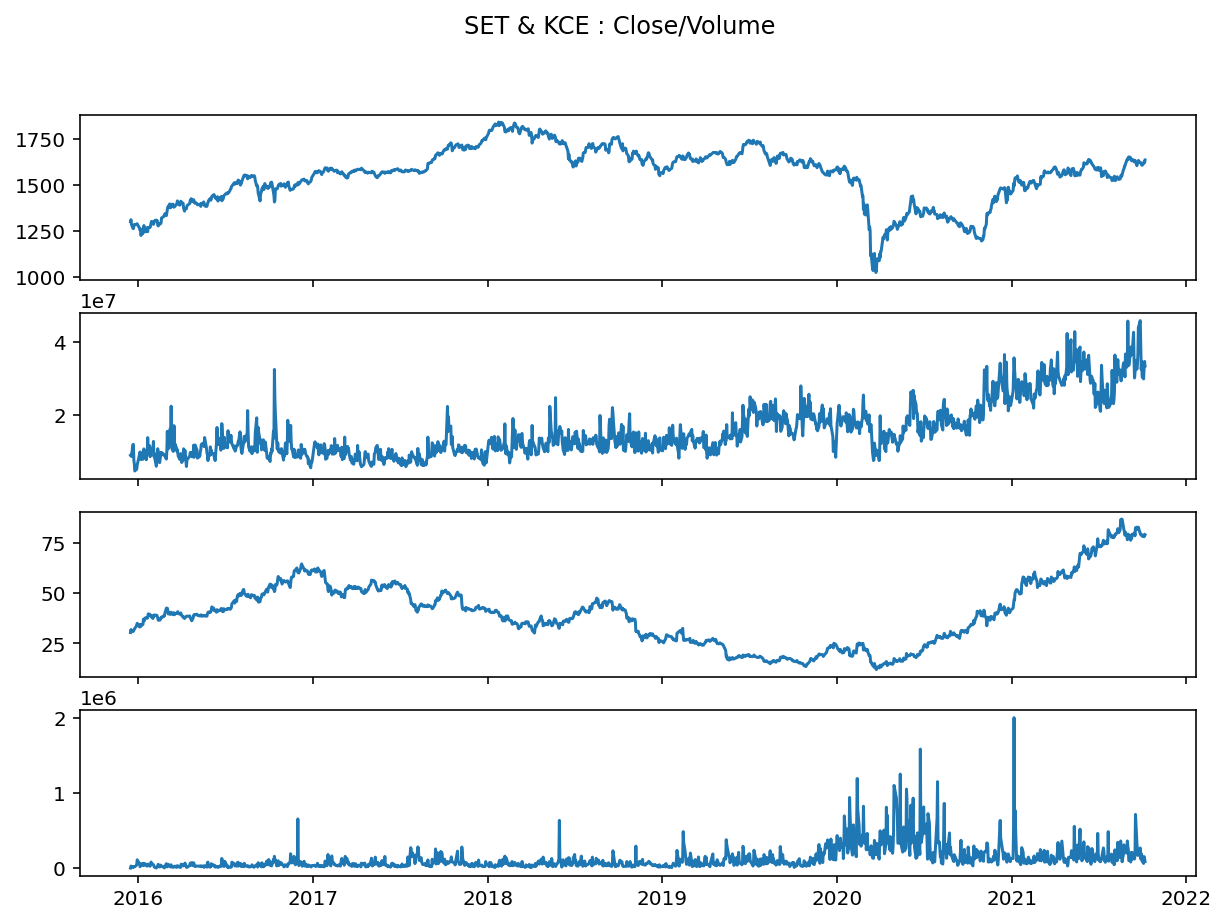

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

fig, axs = plt.subplots(4,sharex=True)
fig.suptitle('SET & KCE : Close/Volume')
axs[0].plot(df.index, df['SET'])
axs[1].plot(df.index, df['SET_Vol'])
axs[2].plot(df.index, df['KCE'])
axs[3].plot(df.index, df['KCE_Vol'])

In [7]:
df_train = df[df.index<'2020-01-01']
df_test  = df[df.index>='2020-01-01']

In [8]:
len(df_train),len(df_test),len(df)

(988, 428, 1416)

### Scale Data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
rescaled = scaler.fit_transform(df.values)

scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
scaler.fit(df)

MinMaxScaler()

In [13]:
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

In [14]:
scaled_train.shape

(988, 4)

In [15]:
scaled_train

array([[0.33721301, 0.10443067, 0.24588629, 0.        ],
       [0.35098834, 0.09922525, 0.26595318, 0.01358561],
       [0.31977901, 0.09712145, 0.25257525, 0.01002912],
       ...,
       [0.6808717 , 0.15531899, 0.17391304, 0.15367805],
       [0.67987723, 0.19790278, 0.17391304, 0.15538337],
       [0.68186618, 0.09154116, 0.16722408, 0.05309767]])

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout

In [17]:
# define generator
length = 60 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [18]:
generator

In [19]:
X,y = generator[0]

In [20]:
len(X),len(y)

(1, 1)

In [21]:
X.shape , y.shape  #60 วัน ทายวันถัดไป

((1, 60, 4), (1, 4))

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [23]:
scaled_train.shape,     scaled_train.shape[0],scaled_train.shape[1]

((988, 4), 988, 4)

In [24]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1]),return_sequences = True))
model.add(Dropout(0.2))


# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           42000     
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
dense (Dense)                (None, 60, 4)             404       
Total params: 42,404
Trainable params: 42,404
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [27]:
#model.fit(generator,epochs=1)#,callbacks=[early_stop])

In [28]:
model.fit(generator,epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/10
928/928 [==============================] - 30s 30ms/step - loss: 0.0092 - val_loss: 0.0407
Epoch 2/10
928/928 [==============================] - 27s 29ms/step - loss: 0.0049 - val_loss: 0.0491


<AxesSubplot:>

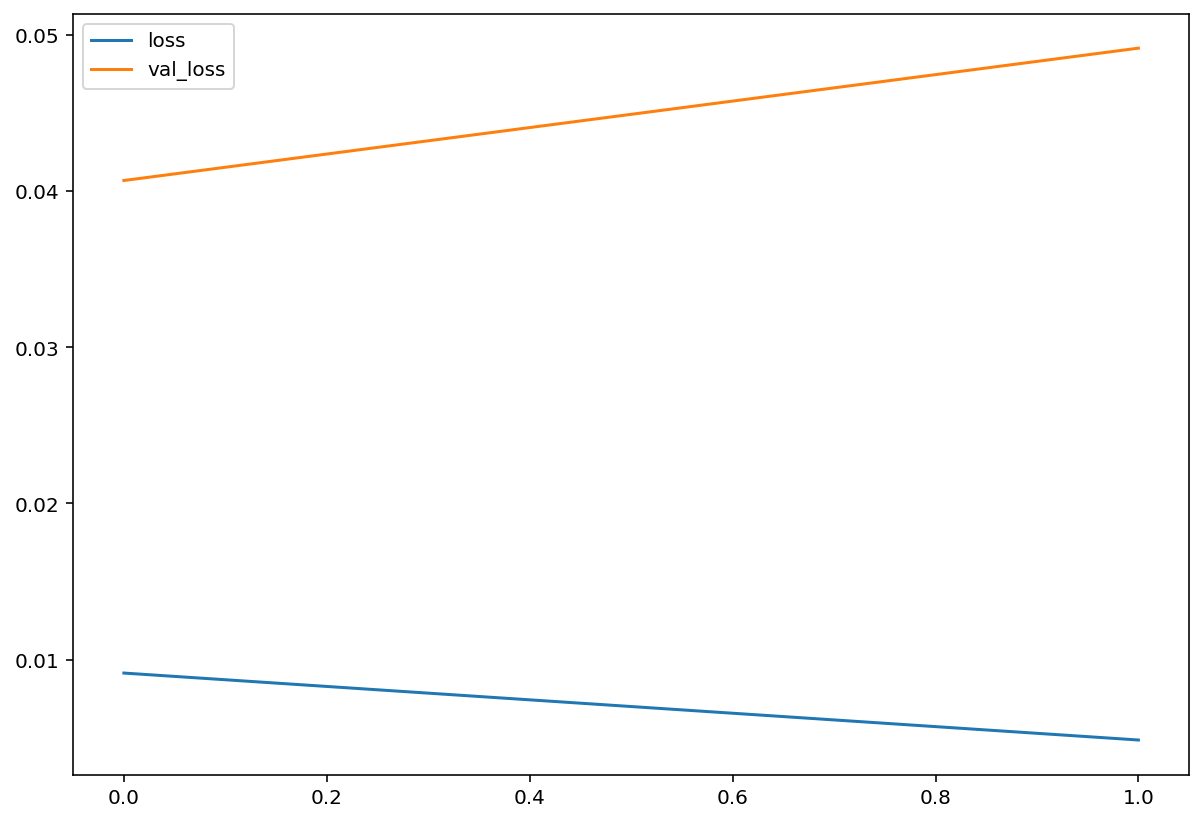

In [29]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [30]:
validation_generator[0][1].shape

(1, 4)

In [31]:
predicted_stock_price = model.predict(validation_generator)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


In [32]:
predicted_stock_price.shape

(368, 60, 4)

In [33]:
o = []
for i in range(len(predicted_stock_price)):
    o.append(predicted_stock_price[i][-1])
    
predicted_stock_price = scaler.inverse_transform(o)

In [34]:
predicted_stock_price

array([[1.26226963e+03, 1.29726338e+07, 2.11516612e+01, 9.88576571e+04],
       [1.26923820e+03, 1.30562497e+07, 2.09198760e+01, 9.73233386e+04],
       [1.26419732e+03, 1.27942402e+07, 2.05723639e+01, 9.41635135e+04],
       ...,
       [1.37470942e+03, 1.17560607e+07, 6.71444729e+01, 1.18492225e+04],
       [1.38870217e+03, 1.18711288e+07, 6.68553590e+01, 1.11184579e+04],
       [1.39558108e+03, 1.20541974e+07, 6.68047317e+01, 8.78230076e+03]])

In [36]:
df_predict = pd.DataFrame(predicted_stock_price)
#df_predict.columns = ['Open','High','Low','Close','Volume']
#df_predict.columns = ['Close','Volume']
df_predict.columns = ['SET','SET_Vol','KCE','KCE_Vol']#,'Ratio']

In [37]:
df_predict

,SET,SET_Vol,KCE,KCE_Vol
0,1262.269625,1.297263e+07,21.151661,98857.657115
1,1269.238203,1.305625e+07,20.919876,97323.338586
2,1264.197320,1.279424e+07,20.572364,94163.513503
3,1291.136256,1.318373e+07,20.626913,100250.774784
4,1310.561761,1.425389e+07,20.714681,105104.376250
...,...,...,...,...
363,1372.797556,1.241675e+07,67.788044,13745.824555
364,1369.378273,1.200754e+07,67.356833,13963.319967
365,1374.709425,1.175606e+07,67.144473,11849.222494
366,1388.702167,1.187113e+07,66.855359,11118.457895


In [38]:
len(df_test)

428

In [39]:
df_predict.index = df_test.index[60:]

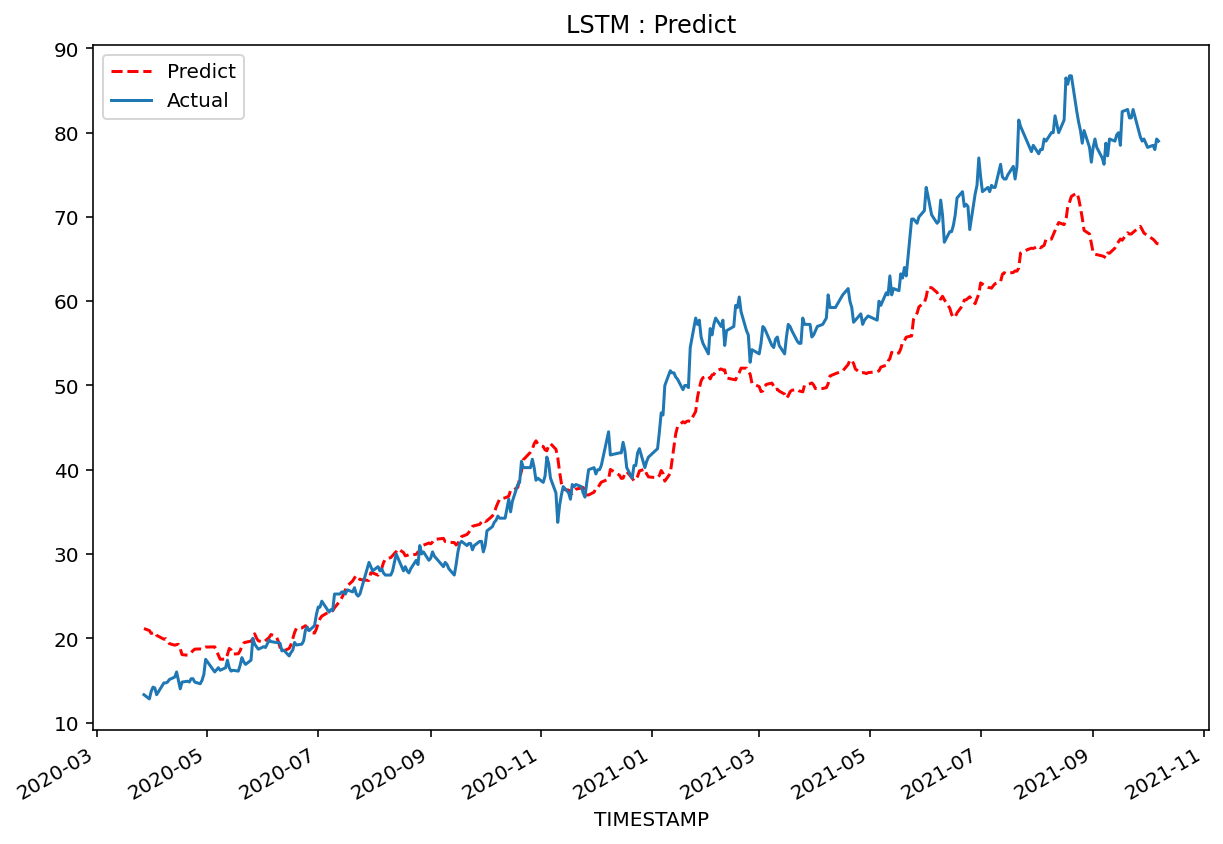

In [40]:
ax = df_predict['KCE'].plot(title='LSTM : Predict',color='red',style='--')
df_test[60:]['KCE'].plot(ax=ax)
ax.legend(['Predict','Actual'])

#### ทดสอบการทายถูกหรือผิด ขึ้นหรือลงในวันถัดไป

In [41]:
df_predict = df_predict[['KCE']].copy()
df_predict['Actual'] = df_test[60:]['KCE']

In [42]:
p = [0]
for i in range(0,len(df_predict['KCE'])-1):
    if(df_predict['KCE'].iloc[i]>df_predict['KCE'].iloc[i+1]):
       p.append(1)
    elif(df_predict['KCE'].iloc[i]<df_predict['KCE'].iloc[i+1]):
       p.append(2)
    else:
       p.append(0)

df_predict['predictUD'] = p

In [43]:
p = [0]
for i in range(0,len(df_predict['Actual'])-1):
    if(df_predict['Actual'].iloc[i]>df_predict['Actual'].iloc[i+1]):
       p.append(1)
    elif(df_predict['Actual'].iloc[i]<df_predict['Actual'].iloc[i+1]):
       p.append(2)
    else:
       p.append(0)

df_predict['ActualUD'] = p

In [44]:
df_predict['resultPredict'] = (df_predict['predictUD'] ^ df_predict['ActualUD'])

In [45]:
(len(df_predict[df_predict['resultPredict']==0])-1)/len(df_predict)

0.41847826086956524